<a href="https://www.kaggle.com/code/muhammadmeftahmafazy/skripsi-meftah?scriptVersionId=127792270" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Mengimpor *Library*

In [1]:
# feature extractoring and preprocessing data
import librosa
import librosa, librosa.display, os, csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler,scale
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score, KFold, StratifiedKFold, cross_val_predict, cross_validate 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve,roc_auc_score, auc, plot_roc_curve
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

#Pytorch
import torch

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

import joblib

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#Other
from IPython.display import Audio
from tqdm import tqdm

In [2]:
!ls ../input/coughvid-19/dataset/archive_wav/archive_wav

00039425-7f3a-42aa-ac13-834aaa2b6b92.wav
0009eb28-d8be-4dc1-92bb-907e53bc5c7a.wav
001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f.wav
0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952.wav
00291cce-36a0-4a29-9e2d-c1d96ca17242.wav
002d28bc-7806-4dfb-9c9b-afa8cb623cac.wav
0037f67c-0d6f-42e6-ab94-66499d4d2bf4.wav
003e1bf6-2ecf-4a00-9198-29db34e8d7ac.wav
0044964d-f7e9-43e3-831f-ae3e6374a9a4.wav
0044cb7b-448c-44e5-8302-ad8bd106fe3e.wav
004c24d8-e8cd-4755-86f6-5a1d8c7920c7.wav
005887c9-4bb1-4f13-86b2-1c7b3cee0881.wav
005b8518-03ba-4bf5-86d2-005541442357.wav
005bca13-18d1-4514-a086-cc8c3fafeeb2.wav
00745765-96ed-4e13-8ca7-7f6b793af78d.wav
00753bb4-cffb-472b-b391-09337558a678.wav
007be9cd-6c5d-467f-a89c-e670fae075b4.wav
00802ac6-0e3b-4bba-bcdc-014f1fde7432.wav
008ba489-31ad-44d8-856b-fcf72369dc46.wav
009aa393-32ab-423f-8e6a-63d8d4d1476b.wav
009b1e22-f451-40ae-9cbf-9f1ff5dec022.wav
00a31212-7c64-4649-b78b-4c7d9ce3156e.wav
00bf9f83-2e8f-47cf-a4f2-97f2beceebc1.wav
00c24aac-b6c8-4065-a999-079cb48fcf86.wav
00c2b443-4746-43

In [3]:
dataset = "../input/coughvid-19/dataset/metadata_wav.csv"
train_csv = pd.read_csv(dataset, index_col=0)
train_csv

,file,status
1,00039425-7f3a-42aa-ac13-834aaa2b6b92.wav,healthy
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a.wav,healthy
5,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f.wav,healthy
10,0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952.wav,healthy
11,00291cce-36a0-4a29-9e2d-c1d96ca17242.wav,healthy
...,...,...
27292,fd849b72-f4bf-4852-9bc2-fd9becc9571e.wav,COVID-19
27300,fd8d6e46-75de-42b3-a7ef-30d5294b915d.wav,COVID-19
27315,fdbabb79-c296-4b93-9e02-06b290916fe7.wav,COVID-19
27503,ff8363d2-016d-4738-9499-4c62480886fb.wav,COVID-19


# Konversi Audio menjadi Spektrogram

total_rows 1926 columns:  2
0037f67c-0d6f-42e6-ab94-66499d4d2bf4


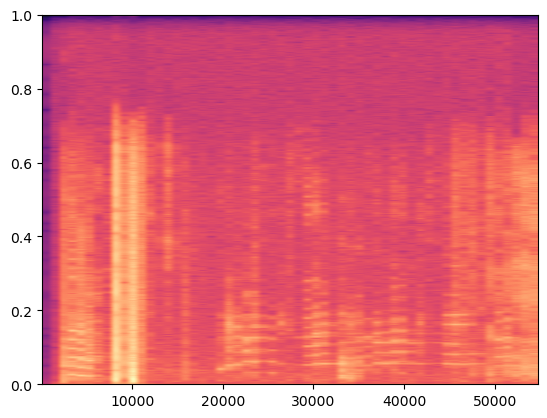

In [4]:
cmap = plt.get_cmap('inferno')
tot_rows = train_csv.shape[0]
print ('total_rows',tot_rows, 'columns: ', train_csv.shape[1])
for i in range(0,1): #Thay range(1) = range(tot_rows)
    source = train_csv.iloc[6]["file"]
    filename = '../input/coughvid-19/dataset/archive_wav/archive_wav/'+source
    y,sr = librosa.load(filename, mono=True, duration=5)
    plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap='magma', sides='default', mode='default', scale='dB');
    #plt.axis('off');
    plt.savefig(f'./{source[:-3].replace(".", "")}.png')
    print (source[:-4]) #Remove the last 4 characters ".wav"
    #plt.clf() 

# Ekstraksi Fitur

## Ekstraksi fitur saat ini terdapat 6 ekstraksi yang nantinya kemungkinan akan bertambah :

*     Chroma Short Time Fourier Transform (STFT)
*     Spectral Centroid
*     Spectral Bandwidth
*     Spectral Rolloff
*     Zero Crossing Rate
*     Mel Frequency Cepstral Coefficient (MFCC)

In [5]:
# #Membuat Header
# header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
# for i in range(1, 11):
#     header += f' mfcc{i}'
# header += ' label'
# header = header.split()
# print(header)

In [6]:
# #Proses Ekstraksi Fitur
# file = open('data_new_extended.csv', 'w')
# with file:
#     writer = csv.writer(file)
#     writer.writerow(header)
# # data_new_extended = pd.read_csv('./data_new_extended.csv')
# #print ('data_new_extended\n',data_new_extended)
# for i in tqdm(range(train_csv.shape[0])):
#         source = train_csv.iloc[i]["file"]
# #         print ('source',source)
#         file_name = '../input/coughvid-19/dataset/archive_wav/archive_wav/'+source
#         label =  train_csv.iloc[i]["status"]
# #         print ('\status', label)
#         y,sr = librosa.load(file_name, mono=True, duration=5)
#         chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
# #         chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
# #         chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
# #         chroma_vqt = librosa.feature.chroma_vqt(y=y, sr=sr, intervals=[])
# #         mel_spectro = librosa.feature.melspectrogram(y=y, sr=sr)
#         rmse = librosa.feature.rms(y=y)
#         spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr,hop_length=1024)
#         spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr,hop_length=1024)
#         rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr,hop_length=1024) #Nên có hop-length
#         #print ('spec_cent',spec_cent, 'shape:',spec_cent.shape)
#         #print ('spec_bw',spec_bw, 'shape:',spec_bw.shape)
#         #print ('rolloff',rolloff, 'shape:',rolloff.shape)
#         zcr = librosa.feature.zero_crossing_rate(y)
#         mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=30)
#         #print ('mfcc',mfcc)
        
# # mendapatkan nilai rata rata, perlu dimasukkan ke var to_append {np.mean(chroma_cqt)} {np.mean(chroma_vqt)} {np.mean(chroma_cens)} {np.mean(mel_spectro)}
#         to_append = f'{np.mean(chroma_stft)}  {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
#         #np.mean nilai rata-rata
#         librosa.display.specshow(mfcc, x_axis='time') #Show MFCC
#         plt.title('MFCC')
#         #plt.show()
        
#         for e in mfcc:
#             to_append += f' {np.mean(e)}'
#         to_append += f' {label}'
#         value = [str(source)]
#         value.extend(to_append.split())
#         file = open('./data_new_extended.csv', 'a')
#         with file:
#             writer = csv.writer(file)
#             writer.writerow(value)

# Mengunduh Data *CSV*

In [7]:
# Downloading the received file
from IPython.display import HTML
import pandas as pd
import numpy as np

def create_download_link(title = "Download CSV file", filename = "./data_new_extended.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='./data_new_extended.csv')

# Inisial Dataset

In [8]:
#Panggil Dataset
data = pd.read_csv("../input/coughvid-19/dataset/data_mfcc30.csv")

In [9]:
#Menghapus kolom nama file
data_new = data.drop('filename', axis=1)

In [10]:
#Mengubah label menjadi numerik
data_new['label'].replace(['healthy', 'COVID-19'], [0,1], inplace=True)

In [11]:
# memisahkan atribut pada dataset dan menyimpannya pada sebuah variabel. 
# array ke-16 untuk dataset 10 mfcc
# array ke-26 untuk dataset 20 mfcc
# array ke-36 untuk dataset 30 mfcc
X = data_new[data_new.columns[:36]]

# memisahkan label pada dataset dan menyimpannya pada sebuah variabel
y = data_new['label']

# Klasifikasi menggunakan *SVM* dengan Stratified K-Fold

In [12]:
# # Inisialisasi objek stratified k-fold dengan inisial skf
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# # Melakukan scaling pada data
# scaler = StandardScaler()

# results=[]

# # Inisialisasi objek SVM
# pipe = SVC(kernel='rbf',  C=1, gamma=0.01, probability=True)
# # pipe = SVC(kernel='poly',  C=1.0, gamma='scale', probability=True)
# # pipe = SVC(kernel='linear',  C=1.0, gamma='scale', probability=True)
# # pipe = SVC(kernel='sigmoid',  C=1.0, gamma='scale', probability=True)

# # Loop untuk setiap fold
# for train_index, test_index in skf.split(X, y):
    
#     # Memisahkan data untuk training dan testing
#     X_train, X_test = X.values[train_index], X.values[test_index]
#     y_train, y_test = y.values[train_index], y.values[test_index]
    
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
    
#     # Melakukan training pada model SVM
#     pipe.fit(X_train, y_train)
    
#     # Melakukan prediksi pada data testing
#     y_pred = pipe.predict(X_test)
    
#     # Hitung Probabilitas
#     y_prob = pipe.decision_function(X_test)
    
#     # Confusion Matrix
#     confusion_matrix = metrics.confusion_matrix(y_test, y_pred, labels=[0,1])

#     cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

#     cm_display.plot()
#     plt.show()
     
#     Accuracy = metrics.accuracy_score(y_test, y_pred)
#     Precision = metrics.precision_score(y_test, y_pred)
#     Sensitivity_recall = metrics.recall_score(y_test, y_pred)
#     Specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
    
# #     print(classification_report(y_test, y_pred))
#     plot_roc_curve(pipe, X_test, y_test)
#     plt.show()
    
#     # AUC (y_prob[:,1] khusus untuk random forest dan knn)
#     auc = roc_auc_score(y_test, y_prob)
    
#      # Simpan hasil ke dalam list
#     results.append({'Accuracy': Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity, 'AUC':auc})
    
#     # Buat dataframe dari hasil
#     df = pd.DataFrame(results)

#     # Print dataframe
#     print(df)

# Klasifikasi menggunakan *SVM* dengan Stratified K-Fold dan Random Under Sampling

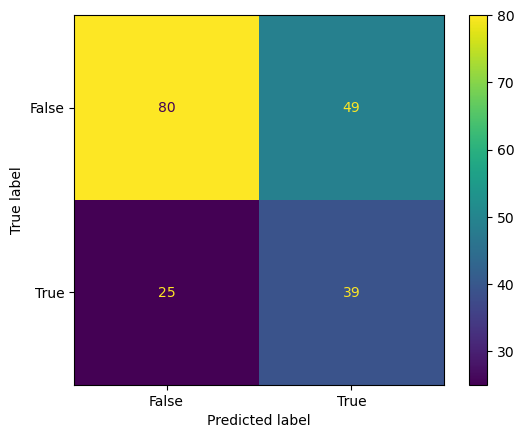

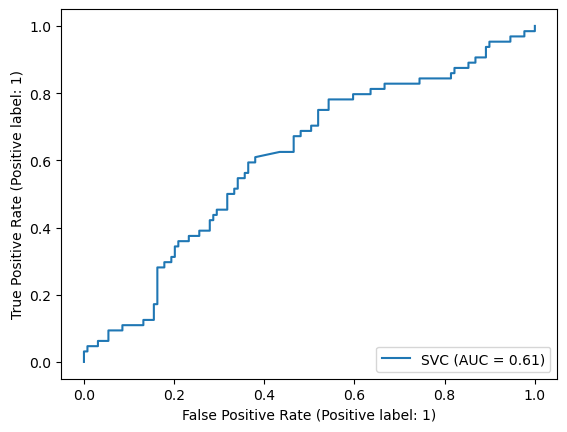

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0   0.61658   0.443182            0.609375     0.620155  0.608891


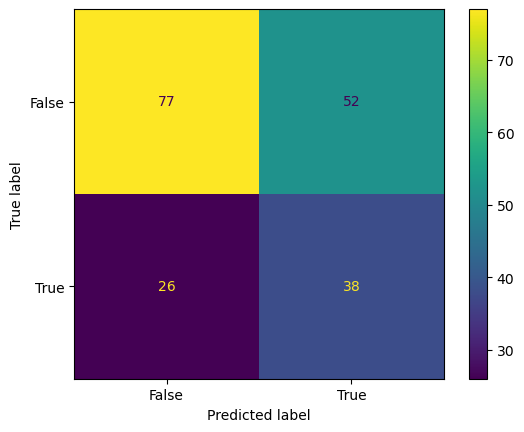

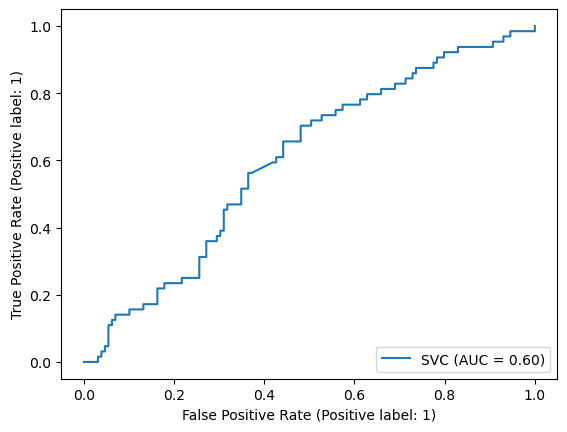

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.616580   0.443182            0.609375     0.620155  0.608891
1  0.595855   0.422222            0.593750     0.596899  0.600412


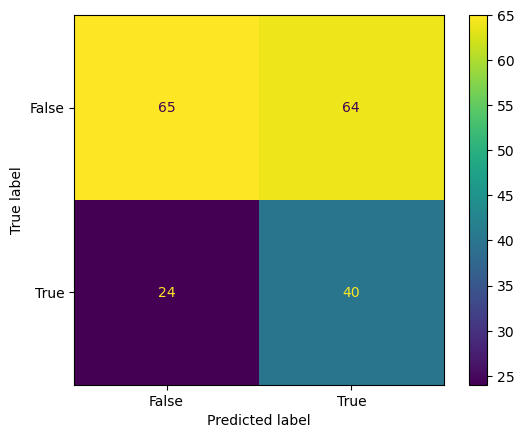

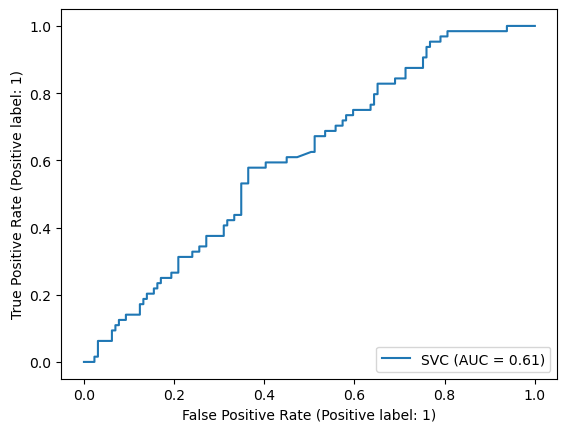

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.616580   0.443182            0.609375     0.620155  0.608891
1  0.595855   0.422222            0.593750     0.596899  0.600412
2  0.544041   0.384615            0.625000     0.503876  0.606468


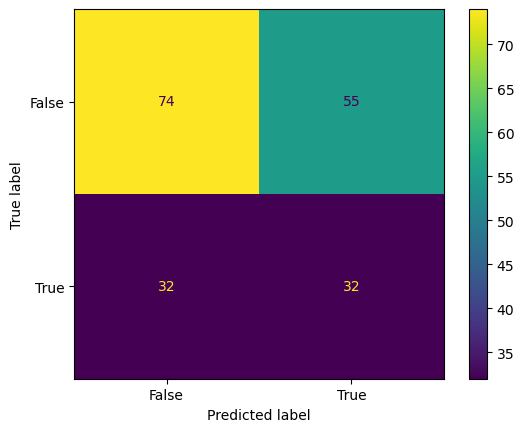

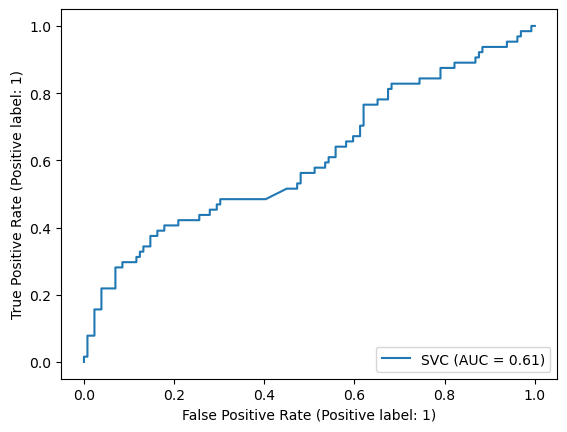

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.616580   0.443182            0.609375     0.620155  0.608891
1  0.595855   0.422222            0.593750     0.596899  0.600412
2  0.544041   0.384615            0.625000     0.503876  0.606468
3  0.549223   0.367816            0.500000     0.573643  0.606468


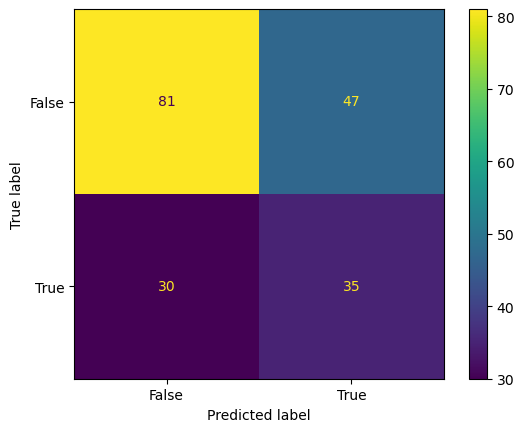

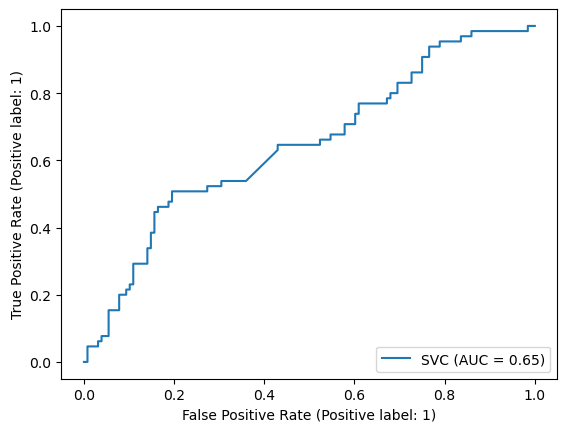

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.616580   0.443182            0.609375     0.620155  0.608891
1  0.595855   0.422222            0.593750     0.596899  0.600412
2  0.544041   0.384615            0.625000     0.503876  0.606468
3  0.549223   0.367816            0.500000     0.573643  0.606468
4  0.601036   0.426829            0.538462     0.632812  0.646034


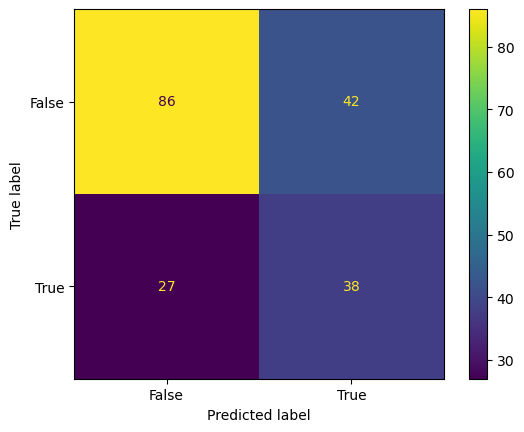

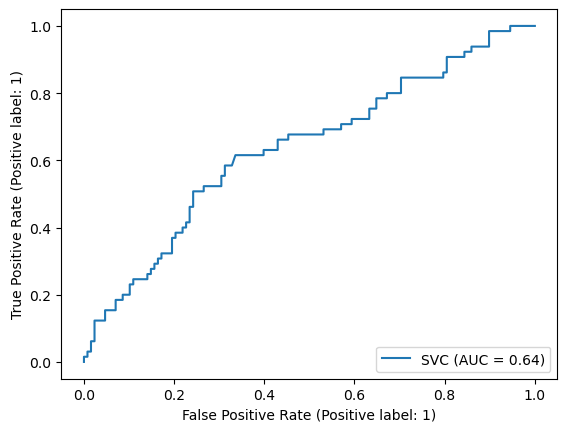

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.616580   0.443182            0.609375     0.620155  0.608891
1  0.595855   0.422222            0.593750     0.596899  0.600412
2  0.544041   0.384615            0.625000     0.503876  0.606468
3  0.549223   0.367816            0.500000     0.573643  0.606468
4  0.601036   0.426829            0.538462     0.632812  0.646034
5  0.642487   0.475000            0.584615     0.671875  0.635577


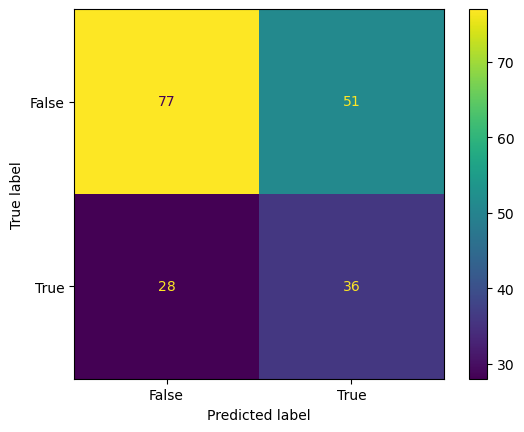

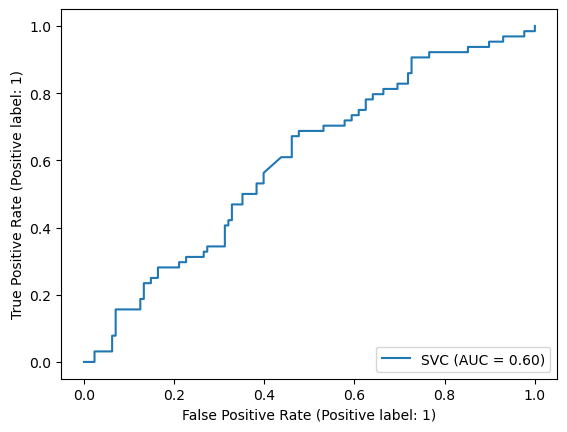

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.616580   0.443182            0.609375     0.620155  0.608891
1  0.595855   0.422222            0.593750     0.596899  0.600412
2  0.544041   0.384615            0.625000     0.503876  0.606468
3  0.549223   0.367816            0.500000     0.573643  0.606468
4  0.601036   0.426829            0.538462     0.632812  0.646034
5  0.642487   0.475000            0.584615     0.671875  0.635577
6  0.588542   0.413793            0.562500     0.601562  0.597778


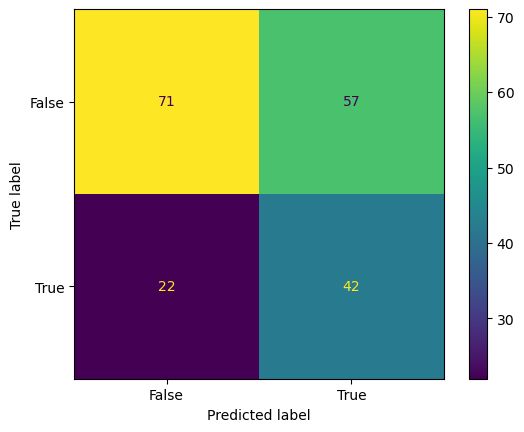

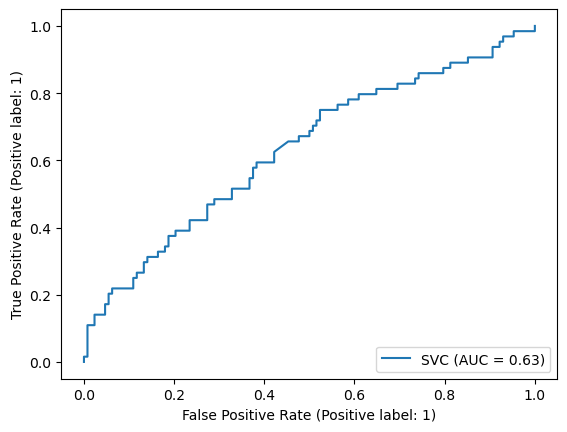

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.616580   0.443182            0.609375     0.620155  0.608891
1  0.595855   0.422222            0.593750     0.596899  0.600412
2  0.544041   0.384615            0.625000     0.503876  0.606468
3  0.549223   0.367816            0.500000     0.573643  0.606468
4  0.601036   0.426829            0.538462     0.632812  0.646034
5  0.642487   0.475000            0.584615     0.671875  0.635577
6  0.588542   0.413793            0.562500     0.601562  0.597778
7  0.588542   0.424242            0.656250     0.554688  0.632202


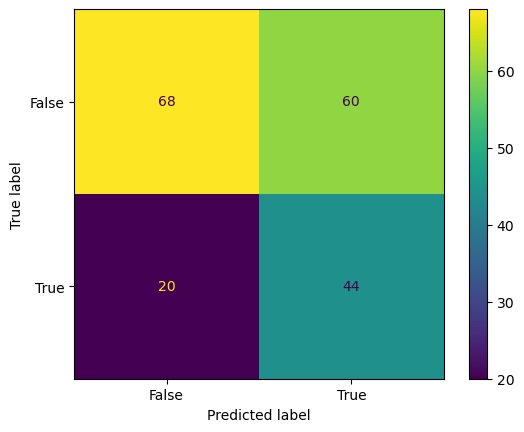

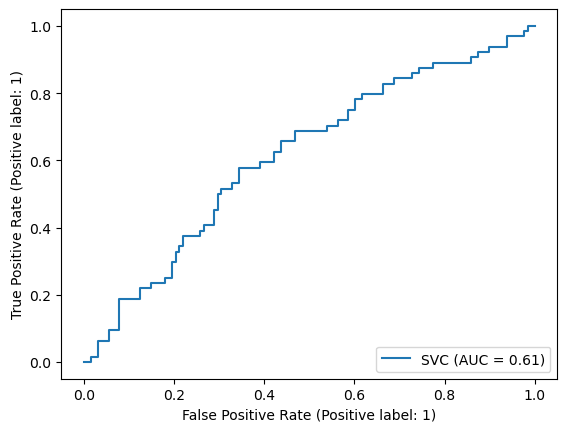

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.616580   0.443182            0.609375     0.620155  0.608891
1  0.595855   0.422222            0.593750     0.596899  0.600412
2  0.544041   0.384615            0.625000     0.503876  0.606468
3  0.549223   0.367816            0.500000     0.573643  0.606468
4  0.601036   0.426829            0.538462     0.632812  0.646034
5  0.642487   0.475000            0.584615     0.671875  0.635577
6  0.588542   0.413793            0.562500     0.601562  0.597778
7  0.588542   0.424242            0.656250     0.554688  0.632202
8  0.583333   0.423077            0.687500     0.531250  0.613770


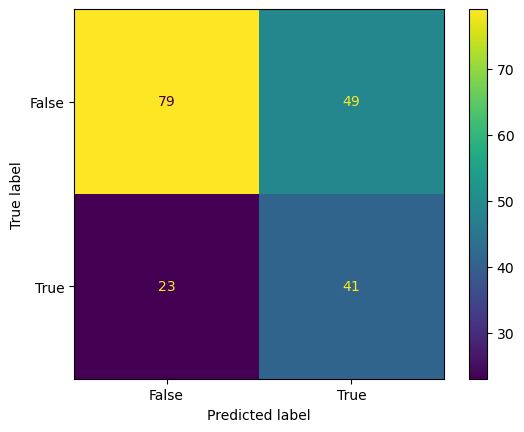

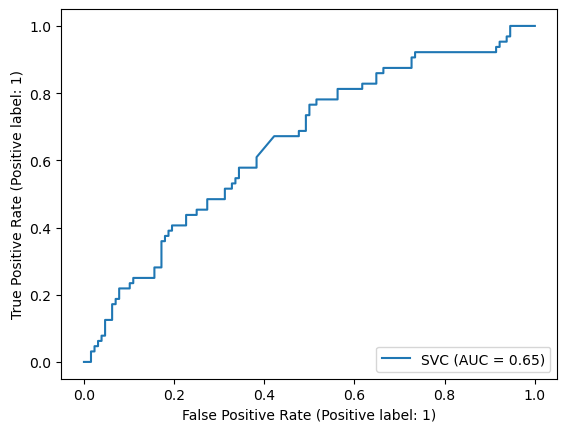

   Accuracy  Precision  Sensitivity_recall  Specificity       AUC
0  0.616580   0.443182            0.609375     0.620155  0.608891
1  0.595855   0.422222            0.593750     0.596899  0.600412
2  0.544041   0.384615            0.625000     0.503876  0.606468
3  0.549223   0.367816            0.500000     0.573643  0.606468
4  0.601036   0.426829            0.538462     0.632812  0.646034
5  0.642487   0.475000            0.584615     0.671875  0.635577
6  0.588542   0.413793            0.562500     0.601562  0.597778
7  0.588542   0.424242            0.656250     0.554688  0.632202
8  0.583333   0.423077            0.687500     0.531250  0.613770
9  0.625000   0.455556            0.640625     0.617188  0.652588


In [13]:
# Inisialisasi objek stratified k-fold dengan inisial skf
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Inisial Under Sampling
rus = RandomUnderSampler(random_state=42)

# Melakukan scaling pada data
scaler = StandardScaler()

results=[]

# Inisialisasi objek SVM
pipe = SVC(kernel='rbf',  C=1.0, gamma='auto', probability=True)
# pipe = SVC(kernel='poly',  C=1.0, gamma='auto', probability=True)
# pipe = SVC(kernel='linear',  C=0.2, gamma='auto', probability=True)
# pipe = SVC(kernel='sigmoid',  C=0.2, gamma='auto', probability=True)

# Loop untuk setiap fold
for train_index, test_index in skf.split(X, y):
    
    # Memisahkan data untuk training dan testing
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    # Melakukan undersampling pada data training
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

    X_train_res = scaler.fit_transform(X_train_res)
    X_test = scaler.transform(X_test)
    
    # Melakukan training pada model SVM
    pipe.fit(X_train_res, y_train_res)
    
    # Melakukan prediksi pada data testing
    y_pred = pipe.predict(X_test)
    
    # Hitung Probabilitas
    y_prob = pipe.decision_function(X_test)
    
    # Confusion Matrix
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    plt.show()

    # print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

    Accuracy = metrics.accuracy_score(y_test, y_pred)
    Precision = metrics.precision_score(y_test, y_pred)
    Sensitivity_recall = metrics.recall_score(y_test, y_pred)
    Specificity = metrics.recall_score(y_test, y_pred, pos_label=0)

    # print(classification_report(y_test, y_pred))
    plot_roc_curve(pipe, X_test, y_test)
    plt.show()

    # AUC (y_prob[:,1] khusus untuk random forest dan knn)
    auc = roc_auc_score(y_test, y_prob)

    # Simpan hasil ke dalam list
    results.append({'Accuracy': Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity, 'AUC':auc})

    # Buat dataframe dari hasil
    df = pd.DataFrame(results)

    # Print dataframe
    print(df)